In [1]:
import numpy as np
import pandas as pd
import re

# Plotting and Metrics imports
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Data Processing imports
from sklearn.model_selection import train_test_split
import re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')

# Feature Extraction imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Doc2Vec imports
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Models imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Fake News Net dataset

In [2]:
import pandas as pd

# Loading the data
buzzfeed_fake = pd.read_csv('04fakenewsnet/BuzzFeed_fake_news_content.csv')
buzzfeed_real = pd.read_csv('04fakenewsnet/BuzzFeed_real_news_content.csv')
politifact_fake = pd.read_csv('04fakenewsnet/PolitiFact_fake_news_content.csv')
politifact_real = pd.read_csv('04fakenewsnet/PolitiFact_real_news_content.csv')

# Combining fake news data from both sources
fake_df = pd.concat([buzzfeed_fake, politifact_fake], ignore_index=True)

# Combining real news data from both sources
real_df = pd.concat([buzzfeed_real, politifact_real], ignore_index=True)

# Adding labels to the dataframes
fake_df['label'] = 'fake'
real_df['label'] = 'true'

# Combining both fake and real data into one dataframe
fnn_df = pd.concat([fake_df, real_df], ignore_index=True)

fnn_df = fnn_df[['text', 'label']]
fnn_df.columns = ['Statement', 'Label']

In [3]:
print(fnn_df.head())

                                           Statement Label
0  I woke up this morning to find a variation of ...  fake
1  Former President Bill Clinton and his Clinton ...  fake
2  After collapsing just before trying to step in...  fake
3  Donald Trump is, well, deplorable. He’s sugges...  fake
4                    Website is Down For Maintenance  fake


In [4]:
# Split the data into 80% training and 20% validation
fnn_train, fnn_valid = train_test_split(fnn_df, test_size=0.2, random_state=42, stratify=fnn_df['Label'])

# Reset index for both dataframes
fnn_train = fnn_train.reset_index(drop=True)
fnn_valid = fnn_valid.reset_index(drop=True)

#### Study the dataset (Fake News Net)

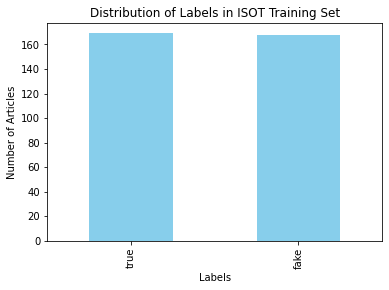

In [5]:
# Distribution

# Plotting the distribution of labels in the training set
fnn_train['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels in ISOT Training Set')
plt.xlabel('Labels')
plt.ylabel('Number of Articles')
plt.show()

In [6]:
# Missing value

# Display the number of missing values for each column in the training set
missing_values = fnn_train.isnull().sum()
print("Missing values in ISOT Training Set:")
print(missing_values)


Missing values in ISOT Training Set:
Statement    0
Label        0
dtype: int64


### Data Preprocessing

In [7]:
# Data Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove stopwords and lemmatize
    text = ' '.join(lemmatizer.lemmatize(token) for token in text.split() if token not in stop_words)
    return text

fnn_train['Statement'] = fnn_train['Statement'].apply(normalize_text)
fnn_valid['Statement'] = fnn_valid['Statement'].apply(normalize_text)

def map_labels(label):
    true_labels = ["true", "mostly-true", "half-true"]
    return "true" if label in true_labels else "fake"

fnn_train['Label'] = fnn_train['Label'].apply(map_labels)
fnn_valid['Label'] = fnn_valid['Label'].apply(map_labels)

In [8]:
print(fnn_train.head())

                                           Statement Label
0  thanks part declassification defense intellige...  fake
1  total state district columbia allow early voti...  fake
2  ap photo mcconnell pelosi ryan seek deal gover...  true
3  wouldnt nice could kick bigot country well tha...  fake
4  trump happy didnt bring bill clinton affair do...  fake


In [9]:
print(fnn_train.columns)

Index(['Statement', 'Label'], dtype='object')


In [10]:
# BoW

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)  # Limiting to 5000 most frequent words for simplicity

# Fit and transform the training data from LIAR dataset
X_train_bow = vectorizer.fit_transform(fnn_train['Statement'])

# Transform the validation and test data
X_valid_bow = vectorizer.transform(fnn_valid['Statement'])

# Print some information
print(f"Shape of BoW training data: {X_train_bow.shape}")
print(f"Shape of BoW validation data: {X_valid_bow.shape}")

y_train = fnn_train['Label']
y_valid = fnn_valid['Label']


Shape of BoW training data: (337, 5000)
Shape of BoW validation data: (85, 5000)


In [11]:
# BoW + Decision Tree

# Initialize the Decision Tree Classifier
clf_tree = DecisionTreeClassifier()

# Train the classifier using the training data
clf_tree.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_tree = clf_tree.predict(X_valid_bow)

# Evaluate the performance
accuracy_tree = accuracy_score(y_valid, y_pred_tree)
print(f"Validation Accuracy: {accuracy_tree * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_tree))


Validation Accuracy: 25.88%

Classification Report:
              precision    recall  f1-score   support

        fake       0.30      0.35      0.32        43
        true       0.20      0.17      0.18        42

    accuracy                           0.26        85
   macro avg       0.25      0.26      0.25        85
weighted avg       0.25      0.26      0.25        85



In [12]:
# BoW + Random Froest

# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier()

# Train the classifier using the training data
clf_rf.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_bow)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 25.88%

Classification Report:
              precision    recall  f1-score   support

        fake       0.27      0.28      0.28        43
        true       0.24      0.24      0.24        42

    accuracy                           0.26        85
   macro avg       0.26      0.26      0.26        85
weighted avg       0.26      0.26      0.26        85



In [13]:
#BoW + SVM

# Initialize the SVM Classifier
clf_svm_bow = SVC(kernel='linear', probability=True)

# Train the classifier using the BoW training data
clf_svm_bow.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_svm_bow = clf_svm_bow.predict(X_valid_bow)

# Evaluate the performance
accuracy_svm_bow = accuracy_score(y_valid, y_pred_svm_bow)
print(f"Validation Accuracy for SVM with BoW: {accuracy_svm_bow * 100:.2f}%\n")
print("Classification Report for SVM with BoW:")
print(classification_report(y_valid, y_pred_svm_bow))


Validation Accuracy for SVM with BoW: 24.71%

Classification Report for SVM with BoW:
              precision    recall  f1-score   support

        fake       0.29      0.33      0.30        43
        true       0.19      0.17      0.18        42

    accuracy                           0.25        85
   macro avg       0.24      0.25      0.24        85
weighted avg       0.24      0.25      0.24        85



In [14]:
#BoW + KNN neighbours 5

# Initialize the KNN Classifier
clf_knn_bow = KNeighborsClassifier(n_neighbors=5)  # You can tune the 'n_neighbors' parameter

# Train the classifier using the BoW training data
clf_knn_bow.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_knn_bow = clf_knn_bow.predict(X_valid_bow)

# Evaluate the performance
accuracy_knn_bow = accuracy_score(y_valid, y_pred_knn_bow)
print(f"Validation Accuracy for KNN with BoW: {accuracy_knn_bow * 100:.2f}%\n")
print("Classification Report for KNN with BoW:")
print(classification_report(y_valid, y_pred_knn_bow))


Validation Accuracy for KNN with BoW: 50.59%

Classification Report for KNN with BoW:
              precision    recall  f1-score   support

        fake       0.51      0.74      0.60        43
        true       0.50      0.26      0.34        42

    accuracy                           0.51        85
   macro avg       0.50      0.50      0.47        85
weighted avg       0.50      0.51      0.48        85



In [15]:
#　TF-IDF

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(fnn_train['Statement'])

# Transform the validation data
X_valid_tfidf = tfidf_vectorizer.transform(fnn_valid['Statement'])


In [16]:
# TF-IDF + Decision Tree

# Initialize the Decision Tree Classifier
clf_tree_tfidf = DecisionTreeClassifier()

# Train the classifier using the training data
clf_tree_tfidf.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_tree_tfidf = clf_tree_tfidf.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_tree_tfidf = accuracy_score(y_valid, y_pred_tree_tfidf)
print(f"Validation Accuracy: {accuracy_tree_tfidf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_tree_tfidf))


Validation Accuracy: 24.71%

Classification Report:
              precision    recall  f1-score   support

        fake       0.29      0.33      0.30        43
        true       0.19      0.17      0.18        42

    accuracy                           0.25        85
   macro avg       0.24      0.25      0.24        85
weighted avg       0.24      0.25      0.24        85



In [17]:
# TF-IDF + random forest

# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100)

# Train the classifier using the training data
clf_rf.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 25.88%

Classification Report:
              precision    recall  f1-score   support

        fake       0.28      0.30      0.29        43
        true       0.23      0.21      0.22        42

    accuracy                           0.26        85
   macro avg       0.26      0.26      0.26        85
weighted avg       0.26      0.26      0.26        85



In [18]:
# TF-IDF + SVM

# Initialize the SVC classifier with a linear kernel
clf_svc = SVC(kernel='linear')

# Train the classifier using the training data
clf_svc.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_svc = clf_svc.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_svc = accuracy_score(y_valid, y_pred_svc)
print(f"Validation Accuracy: {accuracy_svc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_svc))


Validation Accuracy: 25.88%

Classification Report:
              precision    recall  f1-score   support

        fake       0.24      0.21      0.22        43
        true       0.28      0.31      0.29        42

    accuracy                           0.26        85
   macro avg       0.26      0.26      0.26        85
weighted avg       0.26      0.26      0.26        85



In [19]:
# TF-IDF with KNN neighbours 5 

# Initialize the KNN classifier
# You can tune the number of neighbors (n_neighbors parameter) as needed.
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
clf_knn.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_knn = clf_knn.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_knn = accuracy_score(y_valid, y_pred_knn)
print(f"Validation Accuracy: {accuracy_knn * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_knn))


Validation Accuracy: 41.18%

Classification Report:
              precision    recall  f1-score   support

        fake       0.37      0.23      0.29        43
        true       0.43      0.60      0.50        42

    accuracy                           0.41        85
   macro avg       0.40      0.41      0.39        85
weighted avg       0.40      0.41      0.39        85



In [20]:
# N-gram representation

# Initialize CountVectorizer with ngram range for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
X_train_ngram = vectorizer.fit_transform(fnn_train['Statement'])

# Transform the validation data
X_valid_ngram = vectorizer.transform(fnn_valid['Statement'])

# Now you can train your models on the X_train_ngram and evaluate on X_valid_ngram


In [21]:
# N-gram + Decision Tree

# Initialize the Decision Tree Classifier
clf_tree_ngram = DecisionTreeClassifier()

# Train the classifier using the n-gram training data
clf_tree_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_tree_ngram = clf_tree_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_tree_ngram = accuracy_score(y_valid, y_pred_tree_ngram)
print(f"Validation Accuracy using n-grams: {accuracy_tree_ngram * 100:.2f}%\n")
print("Classification Report for n-grams:")
print(classification_report(y_valid, y_pred_tree_ngram))


Validation Accuracy using n-grams: 23.53%

Classification Report for n-grams:
              precision    recall  f1-score   support

        fake       0.27      0.30      0.29        43
        true       0.19      0.17      0.18        42

    accuracy                           0.24        85
   macro avg       0.23      0.23      0.23        85
weighted avg       0.23      0.24      0.23        85



In [22]:
# N-gram + random forest

# Initialize the Random Forest Classifier
clf_rf_ngram = RandomForestClassifier()

# Train the classifier using the n-gram training data
clf_rf_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_rf_ngram = clf_rf_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_rf_ngram = accuracy_score(y_valid, y_pred_rf_ngram)
print(f"Validation Accuracy using n-grams with Random Forest: {accuracy_rf_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with Random Forest:")
print(classification_report(y_valid, y_pred_rf_ngram))


Validation Accuracy using n-grams with Random Forest: 27.06%

Classification Report for n-grams with Random Forest:
              precision    recall  f1-score   support

        fake       0.31      0.37      0.34        43
        true       0.21      0.17      0.18        42

    accuracy                           0.27        85
   macro avg       0.26      0.27      0.26        85
weighted avg       0.26      0.27      0.26        85



In [23]:
# N-gram + SVM

# Initialize the SVM classifier with a linear kernel
clf_svm_ngram = SVC(kernel='linear')

# Train the classifier using the n-gram training data
clf_svm_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_svm_ngram = clf_svm_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_svm_ngram = accuracy_score(y_valid, y_pred_svm_ngram)
print(f"Validation Accuracy using n-grams with SVM: {accuracy_svm_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with SVM:")
print(classification_report(y_valid, y_pred_svm_ngram))


Validation Accuracy using n-grams with SVM: 24.71%

Classification Report for n-grams with SVM:
              precision    recall  f1-score   support

        fake       0.29      0.33      0.30        43
        true       0.19      0.17      0.18        42

    accuracy                           0.25        85
   macro avg       0.24      0.25      0.24        85
weighted avg       0.24      0.25      0.24        85



In [24]:
# N-gram + k-NN n=5

# Initialize the KNN classifier with 5 neighbors
clf_knn_ngram = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the n-gram training data
clf_knn_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_knn_ngram = clf_knn_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_knn_ngram = accuracy_score(y_valid, y_pred_knn_ngram)
print(f"Validation Accuracy using n-grams with KNN: {accuracy_knn_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with KNN:")
print(classification_report(y_valid, y_pred_knn_ngram))


Validation Accuracy using n-grams with KNN: 48.24%

Classification Report for n-grams with KNN:
              precision    recall  f1-score   support

        fake       0.49      0.81      0.61        43
        true       0.43      0.14      0.21        42

    accuracy                           0.48        85
   macro avg       0.46      0.48      0.41        85
weighted avg       0.46      0.48      0.42        85



In [25]:
# Doc2Vec

articles_tokenized = [word_tokenize(article.lower()) for article in fnn_train['Statement']]

tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(articles_tokenized)]

model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Get vector for the first document as an example
vector = model.infer_vector(articles_tokenized[0])

# Transform the training statements into vectors
X_train_d2v = [model.infer_vector(words) for words in articles_tokenized]

# Transform the validation statements into vectors
statements_tokenized_valid = [word_tokenize(statement.lower()) for statement in fnn_valid['Statement']]
X_valid_d2v = [model.infer_vector(words) for words in statements_tokenized_valid]

In [26]:
# Doc2Vec + Decision Trees

# Initialize the DecisionTree classifier
clf_dt = DecisionTreeClassifier(random_state=0)

# Train the classifier using the training data
clf_dt.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_dt = clf_dt.predict(X_valid_d2v)

# Evaluate the performance
accuracy_dt = accuracy_score(y_valid, y_pred_dt)
print(f"Validation Accuracy: {accuracy_dt * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_dt))

Validation Accuracy: 29.41%

Classification Report:
              precision    recall  f1-score   support

        fake       0.27      0.23      0.25        43
        true       0.31      0.36      0.33        42

    accuracy                           0.29        85
   macro avg       0.29      0.29      0.29        85
weighted avg       0.29      0.29      0.29        85



In [27]:
# Doc2Vec + Random Forest

# Initialize the RandomForest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifier using the training data
clf_rf.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_d2v)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 27.06%

Classification Report:
              precision    recall  f1-score   support

        fake       0.32      0.40      0.35        43
        true       0.19      0.14      0.16        42

    accuracy                           0.27        85
   macro avg       0.25      0.27      0.26        85
weighted avg       0.25      0.27      0.26        85



In [28]:
# Doc2Vec + SVM

# Initialize the SVM classifier with a linear kernel
clf_svm = SVC(kernel='linear')

# Train the classifier using the training data
clf_svm.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_svm = clf_svm.predict(X_valid_d2v)

# Evaluate the performance
accuracy_svm = accuracy_score(y_valid, y_pred_svm)
print(f"Validation Accuracy: {accuracy_svm * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_svm))


Validation Accuracy: 44.71%

Classification Report:
              precision    recall  f1-score   support

        fake       0.45      0.42      0.43        43
        true       0.44      0.48      0.46        42

    accuracy                           0.45        85
   macro avg       0.45      0.45      0.45        85
weighted avg       0.45      0.45      0.45        85



In [29]:
# Doc2Vec + k-NN n=5

# Initialize the KNN classifier with 5 neighbors
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
clf_knn.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_knn = clf_knn.predict(X_valid_d2v)

# Evaluate the performance
accuracy_knn = accuracy_score(y_valid, y_pred_knn)
print(f"Validation Accuracy: {accuracy_knn * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_knn))


Validation Accuracy: 45.88%

Classification Report:
              precision    recall  f1-score   support

        fake       0.47      0.56      0.51        43
        true       0.44      0.36      0.39        42

    accuracy                           0.46        85
   macro avg       0.46      0.46      0.45        85
weighted avg       0.46      0.46      0.45        85

